# Privacy-Preserving Techniques for LLM Code Completion

This notebook measures and plots the privacy-utility trade-off for code completion using the HumanEval dataset.

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '.')

from src.data import HumanEvalDataLoader
from src.obfuscation import LowObfuscator, HighObfuscator
from src.models import CodeCompletionModel
from src.evaluation import UtilityEvaluator, PrivacyEvaluator
from src.visualization import PrivacyUtilityPlotter

import numpy as np
import matplotlib.pyplot as plt

c:\Users\Andrea\Desktop\JetBrains\privacy-preserving\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load HumanEval Dataset

Load the first 20 examples from the openai/openai_humaneval test split.

In [2]:
data_loader = HumanEvalDataLoader(num_examples=20)
data_loader.load_dataset()

prompts = data_loader.get_prompts()
canonical_solutions = data_loader.get_canonical_solutions()

print(f"Loaded {len(prompts)} examples")
print(f"\nExample prompt (first 300 chars):\n{prompts[0][:300]}...")

Loaded 20 examples

Example prompt (first 300 chars):
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, ...


## 3. Define Obfuscation Functions

Two levels of obfuscation:
- **Low**: Rename variables to generic names (var1, var2, etc.)
- **High**: Replace all identifiers with placeholders and strip comments

In [3]:
low_obfuscator = LowObfuscator()
high_obfuscator = HighObfuscator()

low_obfuscated_prompts = [low_obfuscator.obfuscate(p) for p in prompts]
high_obfuscated_prompts = [high_obfuscator.obfuscate(p) for p in prompts]

print("Original prompt (first 200 chars):")
print(prompts[0][:200])
print("\nLow obfuscated (first 200 chars):")
print(low_obfuscated_prompts[0][:200])
print("\nHigh obfuscated (first 200 chars):")
print(high_obfuscated_prompts[0][:200])

Original prompt (first 200 chars):
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given thr

Low obfuscated (first 200 chars):
from typing import List


def has_close_elements(var1: List[float], var2: float) -> bool:


High obfuscated (first 200 chars):
from typing import PLACEHOLDER_0

def PLACEHOLDER_3(PLACEHOLDER_4: PLACEHOLDER_0[PLACEHOLDER_2], PLACEHOLDER_5: PLACEHOLDER_2) -> PLACEHOLDER_1:


## 4. Initialize Code Completion Model

Using Salesforce/codet5-small for code completion.

In [4]:
model = CodeCompletionModel(model_name="Salesforce/codet5-small", device="cpu")
model.load_model()
print("Model loaded successfully")

Model loaded successfully


## 5. Generate Completions

Generate 60 completions total: 20 original, 20 low-obfuscated, 20 high-obfuscated.

In [5]:
print("Generating completions for original prompts...")
original_completions = model.generate_completions_batch(prompts)

print("Generating completions for low-obfuscated prompts...")
low_completions = model.generate_completions_batch(low_obfuscated_prompts)

print("Generating completions for high-obfuscated prompts...")
high_completions = model.generate_completions_batch(high_obfuscated_prompts)

print(f"\nGenerated {len(original_completions) + len(low_completions) + len(high_completions)} total completions")

Generating completions for original prompts...
Generating completions for low-obfuscated prompts...
Generating completions for high-obfuscated prompts...

Generated 60 total completions


## 6. Compute Utility Scores

Using ROUGE-L F1 score to compare completions to canonical solutions.

In [6]:
utility_evaluator = UtilityEvaluator()

original_utility = [utility_evaluator.get_utility_score(c, r) for c, r in zip(original_completions, canonical_solutions)]
low_utility = [utility_evaluator.get_utility_score(c, r) for c, r in zip(low_completions, canonical_solutions)]
high_utility = [utility_evaluator.get_utility_score(c, r) for c, r in zip(high_completions, canonical_solutions)]

print(f"Original - Mean Utility: {np.mean(original_utility):.4f}, Std: {np.std(original_utility):.4f}")
print(f"Low Obf  - Mean Utility: {np.mean(low_utility):.4f}, Std: {np.std(low_utility):.4f}")
print(f"High Obf - Mean Utility: {np.mean(high_utility):.4f}, Std: {np.std(high_utility):.4f}")

Original - Mean Utility: 0.0579, Std: 0.0746
Low Obf  - Mean Utility: 0.0372, Std: 0.0593
High Obf - Mean Utility: 0.0543, Std: 0.1110


## 7. Compute Privacy Scores

Using normalized Levenshtein distance between obfuscated and original prompts.

In [7]:
privacy_evaluator = PrivacyEvaluator()

original_privacy = [0.0] * len(prompts)
low_privacy = privacy_evaluator.compute_privacy_batch(prompts, low_obfuscated_prompts)
high_privacy = privacy_evaluator.compute_privacy_batch(prompts, high_obfuscated_prompts)

print(f"Original - Mean Privacy: {np.mean(original_privacy):.4f}, Std: {np.std(original_privacy):.4f}")
print(f"Low Obf  - Mean Privacy: {np.mean(low_privacy):.4f}, Std: {np.std(low_privacy):.4f}")
print(f"High Obf - Mean Privacy: {np.mean(high_privacy):.4f}, Std: {np.std(high_privacy):.4f}")

Original - Mean Privacy: 0.0000, Std: 0.0000
Low Obf  - Mean Privacy: 0.8023, Std: 0.0525
High Obf - Mean Privacy: 0.9105, Std: 0.0288


## 8. Create Scatter Plot

Visualize the privacy-utility trade-off.

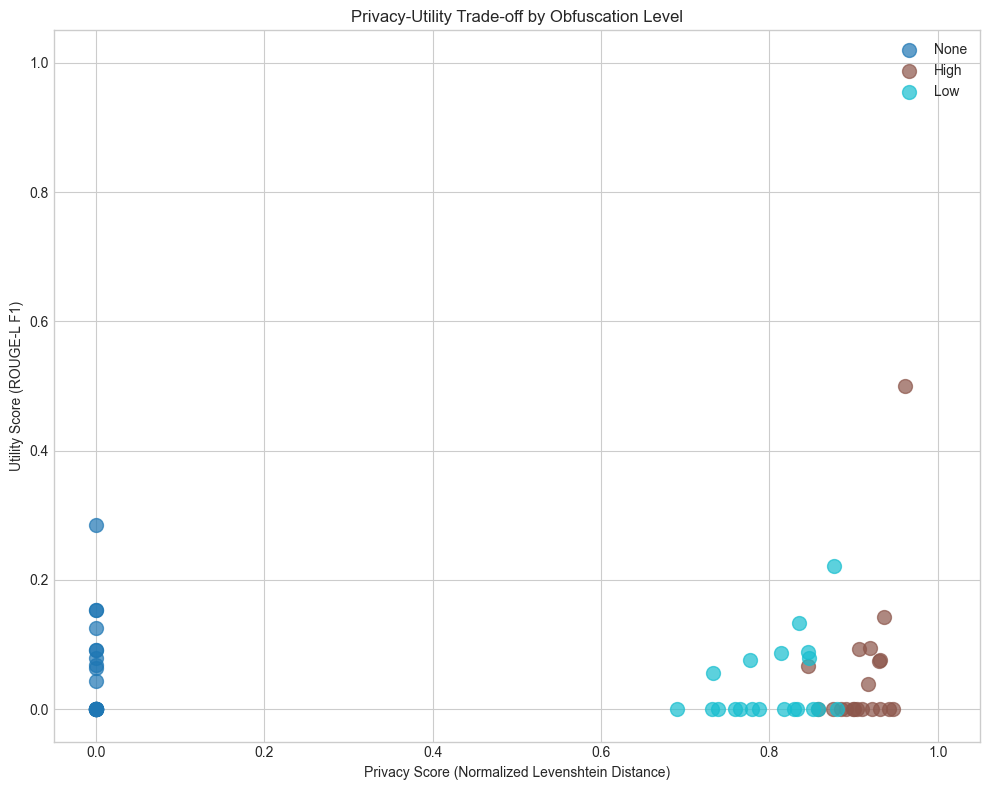

In [8]:
all_privacy = original_privacy + low_privacy + high_privacy
all_utility = original_utility + low_utility + high_utility
all_labels = ['None'] * 20 + ['Low'] * 20 + ['High'] * 20

plotter = PrivacyUtilityPlotter(figure_size=(10, 8))
fig = plotter.create_scatter_plot(
    all_privacy,
    all_utility,
    labels=all_labels,
    title="Privacy-Utility Trade-off by Obfuscation Level",
    xlabel="Privacy Score (Normalized Levenshtein Distance)",
    ylabel="Utility Score (ROUGE-L F1)"
)
plt.show()

## 9. Analysis

Brief analysis of the observed privacy-utility trade-off.

In [11]:
print("="*60)
print("PRIVACY-UTILITY TRADE-OFF ANALYSIS")
print("="*60)
print("\nSummary Statistics:")
print("-"*40)
print(f"{'Level':<10} {'Privacy Mean':>15} {'Utility Mean':>15}")
print("-"*40)
print(f"{'None':<10} {np.mean(original_privacy):>15.4f} {np.mean(original_utility):>15.4f}")
print(f"{'Low':<10} {np.mean(low_privacy):>15.4f} {np.mean(low_utility):>15.4f}")
print(f"{'High':<10} {np.mean(high_privacy):>15.4f} {np.mean(high_utility):>15.4f}")
print("-"*40)

privacy_increase = np.mean(high_privacy) - np.mean(original_privacy)
utility_change = np.mean(high_utility) - np.mean(original_utility)
print(f"\nHigh vs None obfuscation:")
print(f"  Privacy increase: +{privacy_increase:.4f}")
print(f"  Utility change: {utility_change:+.4f}")

PRIVACY-UTILITY TRADE-OFF ANALYSIS

Summary Statistics:
----------------------------------------
Level         Privacy Mean    Utility Mean
----------------------------------------
None                0.0000          0.0579
Low                 0.8023          0.0372
High                0.9105          0.0543
----------------------------------------

High vs None obfuscation:
  Privacy increase: +0.9105
  Utility change: -0.0035



### High Obfuscation Bug

**Why was utility higher with high obfuscation?**

There was a bug in the operation order in `HighObfuscator.obfuscate()`:

**First:** Removed docstrings → functions without body → SyntaxError
**Then:** Attempted to replace identifiers → AST parsing failed → no substitution

**Result:** The "high obfuscated" code had:
- Original names preserved (`has_close_elements`, `numbers`, `threshold`)

The model received practically the same semantic information as the original code, but without the "noise" of docstrings → better completions

**The fix:** Inverted the order:
1. Remove comments
2. Replace identifiers (when code is still valid)
3. Remove docstrings
4. Normalize whitespace

### Low Obfuscation Issues

**Initial approach (utility near zero):**
- Rename local variables to generic names (var1, var2, etc.)
- Preserve function signatures and structure
- Keep comments and docstrings intact

**Problem:** The docstring referenced semantic names (`numbers`, `threshold`) that no longer existed in the code (replaced with `var1`, `var2`). Additionally, type imports like `List` were replaced with generic names (`var1[float]`), creating confusing and inconsistent signals for the model.

**Improved approach:**
- Rename local variables and parameters to generic names (var1, var2, etc.)
- Preserve function names and type annotations
- Remove docstrings to avoid inconsistencies


### Model and Metric Limitations

The model is very small and fails on many examples. Additionally:

CodeT5-small is a seq2seq model, not a true code completion model. It might:
- Generate more "standard" output when receiving cleaner prompts (without docstrings/comments)
- "Transform" the code rather than "complete" it

The ROUGE metric might not be ideal:
- ROUGE measures n-gram overlap, which can favor short and generic outputs


## 10. Save Results

In [10]:
import json

results = {
    'none': {'privacy_scores': original_privacy, 'utility_scores': original_utility},
    'low': {'privacy_scores': low_privacy, 'utility_scores': low_utility},
    'high': {'privacy_scores': high_privacy, 'utility_scores': high_utility}
}

with open('results.json', 'w') as f:
    json.dump(results, f, indent=2)

plotter.save_figure(fig, 'privacy_utility_scatter.png')
print("Results saved to results.json and privacy_utility_scatter.png")

Results saved to results.json and privacy_utility_scatter.png
